#### Copyright 2018 Google LLC.

# Counterintuitive Challenges in ML Debugging

In this Colab, you will explore why ML debugging is harder than traditional debugging by debugging a simple regression problem, with one feature and one label. You will:

* Create the dataset.
* Try to fit the data with a simple model.
* Debug the model.
* Demonstrate exploding gradients.

# Case Study: Debugging a Simple Model

## Create the Dataset

Run the cells below to load libraries.

In [4]:
from os.path import join 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

import catppuccin
mpl.style.use(catppuccin.PALETTE.mocha.identifier)

Create the data. Your data consists of one feature with values 0 to 9, and your labels are the same data with some noise added. In a dataset, by convention, rows are examples and columns are features. To match this convention, transpose your data. Before transposing your vectors, you must convert them to matrices.

In [2]:
features = np.array(range(10))
features = features[:, np.newaxis]
# Create labels by adding noise distributed around 0
labels = features + np.random.random(size=[10,1]) - 0.5

Verify that the data roughly lies in a straight line and, therefore, is easily predicted..


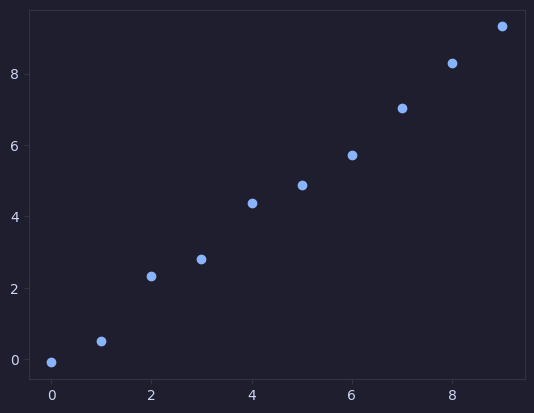

In [5]:
# Visualize the data
plt.scatter(features,labels)

## Fit Simple Data with Simple Model

TensorFlow provides several different APIs. This Colab only demonstrates the Keras API since Keras lets you quickly train models in a few lines of code using high-level APIs. In Keras, the typical neural network is a `sequential` model with fully-connected, or `dense`, layers.

Your dataset is simple. A neural network with just 1 neuron should learn your dataset. Define a neural network with 1 layer having 1 neuron using the model type `keras.Sequential` with the layer type `keras.layers.Dense`. To understand the Keras code, read the code comments. Then run the cell. The code prints the model summary to show a model with 1 layer and 2 parameters (weight and bias).

In [8]:
# Delete any existing assignment to "model"
model = None

# Use a sequential model
model = keras.Sequential()

# Add a layer with 1 neuron. Use the popular "tanh" activation function
model.add(keras.layers.Dense(units=1,             # 1 neuron
                             activation='tanh',   # 'tanh'
                             input_dim=1))         # number of feature cols=1

# Model calculates loss using mean-square error (MSE)
# Model trains using Adam optimizer with learning rate = 0.001
model.compile(optimizer=tf.optimizers.Adam(0.001),
              loss='mse',
             )

print(model.summary())

/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

None


Now, train the model.

In [9]:
model.fit(x=features,
          y=labels,
          epochs=10,    # train for 10 epochs
          batch_size=10,# use 10 examples per batch
          verbose=1)    # verbose=1 prints progress per epoch

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 38.0909
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 38.0810
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 38.0710
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 38.0609
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 38.0507
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 38.0403
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 38.0299
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 38.0194
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 38.0087
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 37.9979


Your loss stubbornly refuses to decrease! Review your approach keeping in mind the guidance on the [model development process](https://developers.google.com/machine-learning/testing-debugging/common/overview).

The following list describes possible actions to debug your model. Read the actions and their explanations to understand how debugging in ML requires you to sort through multiple possibilities at once. If an action sounds promising, experiment by modifying the code above.

* **Transforming data**: You data is not transformed. You can experiment by transforming the data appropriately and retraining the model.
* **Activation function**: The `tanh` activation function cannot predict values >1. Besides, in a regression problem, the last layer should always use the linear activation function. Therefore, should you use  `activation='linear'`?
* **Hyperparameter values**: Should you adjust any hyperparameter values to try reducing loss?
* **Simpler model**: The model development process recommends starting with a simple model. A linear model is simpler than your nonlinear model. Should you use `activation='linear'`?
* **Change optimizer**: Your model uses the Adam optimizer. You can fall back to the gradient descent optimizer by using `optimizer=keras.optimizers.SGD()`.

Consider these actions and experiment where necessary. Then read the following section for the solution.

## Tests:

In [13]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Transformar os dados: normalização
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Teste 1: Função de ativação linear na última camada e otimizador SGD
model1 = keras.Sequential()
model1.add(keras.layers.Dense(units=1, activation='linear', input_dim=features.shape[1]))
model1.compile(optimizer=keras.optimizers.SGD(),
               loss='mse')
print("Modelo 1:")
print(model1.summary())

# Treinar o modelo
model1.fit(x=features_scaled,
           y=labels,
           epochs=10,
           batch_size=10,
           verbose=1)

Modelo 1:


/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 26.1254
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 25.0934
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 24.1023
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 23.1504
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 22.2362
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 21.3582
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 20.5150
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19.7051
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.9274
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.1804


In [14]:
# Teste 2: Ajustar valores de hiperparâmetros, por exemplo, número de unidades e taxa de aprendizado
model2 = keras.Sequential()
model2.add(keras.layers.Dense(units=10, activation='tanh', input_dim=features.shape[1]))
model2.add(keras.layers.Dense(units=1, activation='linear'))
model2.compile(optimizer=tf.optimizers.Adam(0.01),  # Alterando a taxa de aprendizado
               loss='mse')
print("Modelo 2:")
print(model2.summary())

# Treinar o modelo
model2.fit(x=features_scaled,
           y=labels,
           epochs=10,
           batch_size=10,
           verbose=1)


Modelo 2:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 27.1497
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 26.4824
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 25.8169
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 25.1528
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 24.4910
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 23.8321
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.1766
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.5248
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 21.8769
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 21.2329


## Solution: Getting Loss to Decrease

Before trying to adjust specific model parameters, such as the hyperparameter values, you should first check for good development practices. Here, you should start with a linear model because of these two best practices:

* Regression: In a regression problem, the last layer must always be linear.
* Start simple: Since a linear model is simpler than a nonliner model, start with a linear model.

Run the following code to train a linear model and check if your loss decreases. The code displays the loss curve.

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 12.5370
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 10.2569
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 13.8687
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 8.3508
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 17.6168
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 10.4309
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 12.6453
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 8.0403
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 11.4519
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 9.5886


Text(0.5, 1.0, 'Loss Curves')

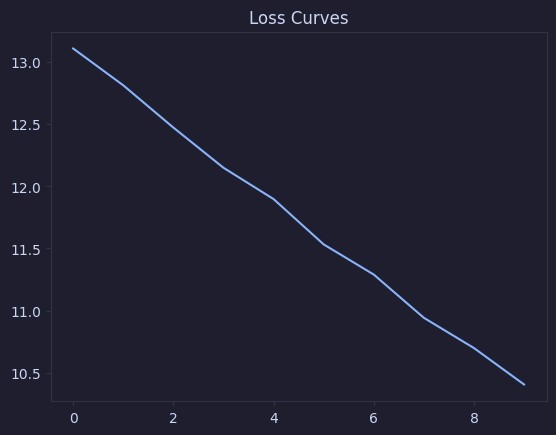

In [15]:
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(1, activation='linear', input_dim=1))
model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse')
trainHistory = model.fit(features, labels, epochs=10, batch_size=1, verbose=1)
# Plot loss curve
plt.plot(trainHistory.history['loss'])
plt.title('Loss Curves')

Your loss decreases, albeit slowly! You're on the right track. How can you get your loss to converge? Experiment with the code above. For the solution, read the following section.

## Solution: Reaching Convergence

Your loss isn't decreasing fast enough. From the guidance on [Learning Rate](https://developers.google.com/machine-learning/crash-course/reducing-loss/learning-rate), you know that you can increase the learning rate to train faster. Run the following code to increase the learning rate to 0.1. The the model reaches convergence quickly.

In [16]:
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(1, activation='linear', input_dim=1))
model.compile(optimizer=tf.optimizers.Adam(0.1), loss='mse')
model.fit(features, labels, epochs=5, batch_size=1, verbose=1)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 1.7389
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 0.3731
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 0.2262
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 0.1755
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.0775


Wonderful, you quickly get a very low loss! Let's confirm the model works by predicting results for values [0,9] and superimposing them on top of the features.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


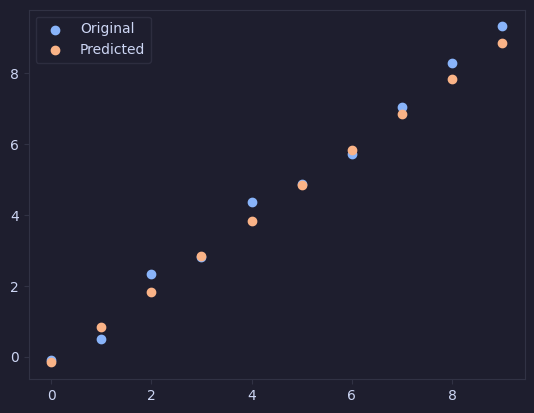

In [18]:
# get predictions
featuresPred = model.predict(features, verbose=1)
# Plot original features and predicted values
featuresPred = np.transpose(featuresPred)
plt.scatter(range(10), labels)
plt.scatter(range(10), featuresPred)
plt.legend(["Original", "Predicted"])

Yes, the predictions match the features very well.

## Summary of Case Study

When debugging ML models, you should first attempt to diagnose the problem and apply the appropriate fix. For example, if you had changed your optimizer using `optimizer='sgd'`, then your model also converges faster. However, the problem was not with the optimizer but with the learning rate. Changing the optimizer only helps because `optimizer='sgd'` has a higher default learning rate than `optimizer='adam'`.

Alternatively, you could train the model for longer with the default learning rate. However, in real-world ML, models take long to train. You should keep your training cycles as short as possible. Therefore, increasing the learning rate is the correct fix.

These options demonstrate how debugging in ML is n-dimensional, and therefore you must use your understanding of model mechanics to narrow down your options. Because running experiments in ML is time consuming, requires careful setup, and can be subject to reproducibility issues, it's important to use your understanding of model mechanics to  narrow down options without having to experiment.

Lastly, according to development best practices, you should transform your feature data appropriately. This Colab did not transform the feature data because transformation is not required for convergence. However, you should always transform data appropriately. Here, you could normalize your feature data using z-score or scale the feature data to [0,1].

# Exploding Gradients

A common problem in model training is a loss that "explodes" or becomes `nan`. A common cause is anomalous feature data, such as outliers and `nan` values, or a high learning rate. The following sections demonstrate these causes.

## Cause: High Learning Rate

In this section, you will create data in the range [0,50] and show that the gradient explodes when you train the model using a learning rate of 0.01. Then you'll reduce the learning rate to make the model converge.

Create and visualize the data by running the following code.

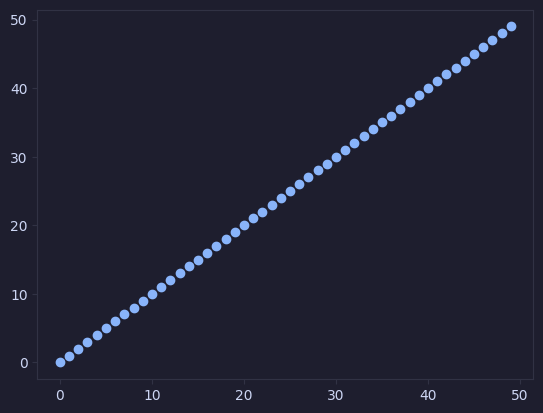

In [19]:
# create data with large values
features = np.array(range(50))
# generate labels
labels = features + np.random.random(features.shape) - 0.5

# Transpose data for input
[features, labels] = [features.transpose(), labels.transpose()]

plt.scatter(range(len(features)), features)

Run the following cell to train a model with a learning rate of 0.01. You will get `inf` for your loss.

In [21]:
# Train on raw data
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_dim=1, activation='linear'))
model.compile(optimizer=keras.optimizers.SGD(0.001), loss='mse')
model.fit(features, labels, epochs=5, batch_size=10, verbose=1)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 46.0090
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 0.1055
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 0.0908
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 0.0885
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 0.1977


To demonstrate that the high learning rate makes the loss explore, reduce the learning rate to `0.001`. Your loss will converge.

# Conclusion

This Colab demonstrated the following principles.

* The n-dimensional nature of debugging in ML makes ML debugging hard.
* For effective debugging, understanding model mechanics is important.
* Start with a simple model.
* Exploding gradients incorrect normalization in the model, mis-configuration of FeatureColumns, etc., than raw data containing NaNs.